# Analysis of embeddings for brobot field day

Using a day from 2023.      
-Generate embeddings for all images    
-extract UMAP projections     
-K-means cluster UMAP projections    
-Get in there and analyze the clusters    


In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
from PIL import Image
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [2]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/opt/sam2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [3]:
import glob
import cv2
image_path_list = glob.glob('/work/20230816_r_ios/*/*.jpg')
image_list = [cv2.resize(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), (512, 512)) for image_path in image_path_list]
# predictor.set_image_batch(image_list[:10])

In [4]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 38.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 30.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 44.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 27.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 24.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import umap
import time
from tqdm import tqdm
all_embeddings = []
start = time.time()
for i in tqdm(range(0, len(image_list), 10), desc="Processing images"):
    predictor.set_image_batch(image_list[i:i+10])
    list_of_embeddings = predictor.get_image_embedding()
    list_embedding_reshaped = list_of_embeddings[:].view(list_of_embeddings[:].size(0), -1)
    all_embeddings.append(list_embedding_reshaped.cpu())
end = time.time()
print(f"Generating and storing embeddings took: {(end-start):.2f} sec")

Processing images: 100%|█████████████████████████████████████████████████████████████████| 189/189 [10:12<00:00,  3.24s/it]

Generating and storing embeddings took: 612.78 sec


In [6]:
import pickle

# Save all_embeddings to a file
with open('embeddings.pkl', 'wb') as file:
    pickle.dump(all_embeddings, file)

print("Embeddings saved successfully.")


Embeddings saved successfully.


In [7]:
flattened_list = []
for sublist in all_embeddings[:120]:
    flattened_list.extend(sublist)
# start = time.time()
# projections = umap.UMAP(n_components=3).fit_transform(flattened_list)
# end = time.time()
# print(f"Generating UMAP projections took: {(end-start):.2f} sec")

In [8]:
from sklearn.manifold import TSNE
flattened_array = np.array(flattened_list)
tsne = TSNE(n_components = 3, random_state=0)
projections = tsne.fit_transform(flattened_array)

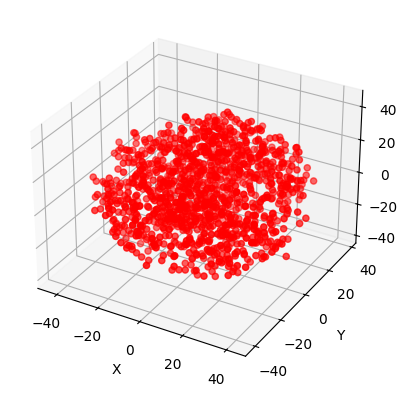

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = [point[0] for point in projections]
y = [point[1] for point in projections]
z = [point[2] for point in projections]

ax.scatter3D(x, y, z, c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [17]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 2

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(projections)

# Print the cluster labels
print(clusters)

[0 0 1 ... 0 0 0]


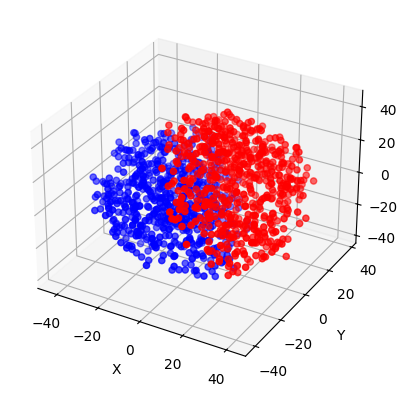

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Change the color of the dots based on the clusters
colors = ['r' if cluster == 0 else 'b' for cluster in clusters]

ax.scatter3D(x, y, z, c=colors, marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

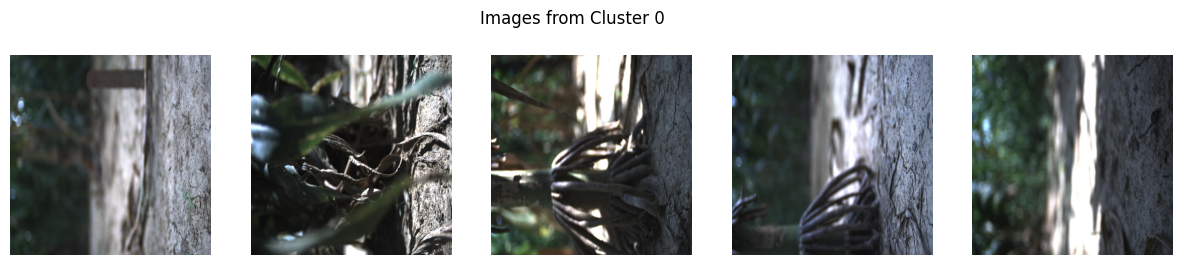

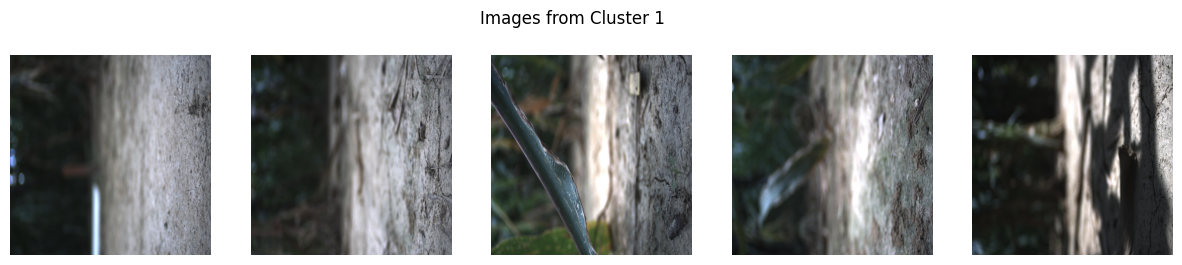

In [19]:
# Get the indices of the images in each cluster
cluster_0_indices = [i for i, cluster in enumerate(clusters) if cluster == 0]
cluster_1_indices = [i for i, cluster in enumerate(clusters) if cluster == 1]

# Display 5 images from cluster 0
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, index in enumerate(cluster_0_indices[50:55]):
    axes[i].imshow(image_list[index])
    axes[i].axis('off')
plt.suptitle('Images from Cluster 0')
plt.show()

# Display 5 images from cluster 1
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, index in enumerate(cluster_1_indices[:5]):
    axes[i].imshow(image_list[index])
    axes[i].axis('off')
plt.suptitle('Images from Cluster 1')
plt.show()